In [1]:

"""
Figures for results of rooftop mapping in Washington D.C.

Figure 1. Study area map, roof materials distribution, and building footprint area.

Figure 2. Example image chunks from satellite imagery (see _plot-image-chunks-DC.ipynb)

Figure 3. Parameter tuning results.

Figure 4. ...

Figure 5. ...

"""

import os
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import earthpy.plot as ep
import seaborn as sns
import matplotlib as mpl
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline

print(os.getcwd())

projdir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/'

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

print("Ready!")

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/code
Ready!


## Fig. 1: Study area map and distribution of training data

- 1a) Distribution of roof material classes
- 1b) Map of the study region
- 1c) Distribution of building sizes by roof material

In [2]:
# Load the footprint data for both ROIs

# Washington D.C.
fp = os.path.join(projdir, 'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
dc_ref = gpd.read_file(fp)
# Denver, Colorado
fp = os.path.join(projdir, 'data/spatial/mod/denver_data/training/denver_data_reference_footprints.gpkg')
denver_ref = gpd.read_file(fp)

# Create a dictionary for data access:
refs = {'DC': dc_ref, 'Denver': denver_ref}

dc_ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [3]:
print(f"DC class distribution:\n{refs['DC']['class_code'].value_counts()}\nDenver class distribution: {refs['Denver']['class_code'].value_counts()}")

DC class distribution:
class_code
CS    37133
ME    36864
SL    15267
UR     1279
WS     1152
TL      924
SH      783
Name: count, dtype: int64
Denver class distribution: class_code
CS    86561
WS    10642
AP     8117
TL     2843
CN     2757
SL      230
TG      228
Name: count, dtype: int64


In [4]:
all_classes = set()
for gdf in refs.values():
    all_classes.update(gdf['class_code'].unique())
print(all_classes)

{'CS', 'WS', 'TL', 'AP', 'TG', 'ME', 'SL', 'UR', 'SH', 'CN'}


In [5]:
# Create a dictionary mapping class code to description


In [6]:
#### Distribution of roof material class counts for each ROI

In [7]:
# Create a color palette for roof materials
all_classes = sorted(all_classes)  # Sort for consistent ordering
class_palette = sns.color_palette('husl', len(all_classes))
color_mapping = dict(zip(all_classes, class_palette))
print(color_mapping)

{'AP': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), 'CN': (0.8616090647292522, 0.536495730113334, 0.19548899031476086), 'CS': (0.6804189127793346, 0.6151497514677574, 0.19405452111445337), 'ME': (0.46810256823426105, 0.6699492535792404, 0.1928958739904499), 'SH': (0.20125317221201128, 0.6907920815379025, 0.47966761189275336), 'SL': (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), 'TG': (0.2197995660828324, 0.6625157876850336, 0.7732093159317209), 'TL': (0.433280341176423, 0.6065273407962815, 0.9585467098271748), 'UR': (0.8004936186423958, 0.47703363533737203, 0.9579547196007522), 'WS': (0.962272393509669, 0.3976451968965351, 0.8008274363432775)}


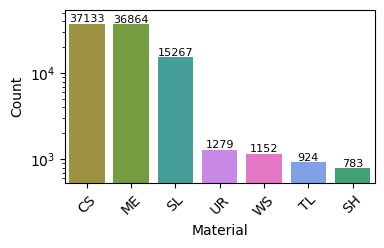

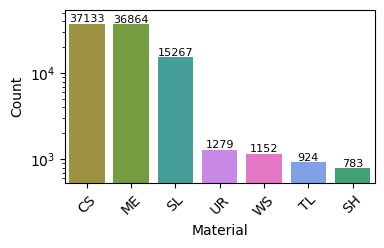

<Figure size 640x480 with 0 Axes>

In [9]:
for roi, ref in refs.items():
    ref = ref.sort_values(by='class_code')
    # Count the occurrences of each class_code
    class_counts = gdf['class_code'].value_counts()
    class_counts = gdf['class_code'].value_counts().reset_index()
    class_counts.columns = ['class_code', 'count']

    # IDentify the color palette for the region
    region_palette = [color_mapping[cls] for cls in class_counts['class_code']]

    # Plot the bar chart, assigning 'hue' to 'class_code'
    plt.figure(figsize=(4, 2.25))
    ax = sns.barplot(
        x='class_code', y='count', data=class_counts, 
        hue='class_code', palette=region_palette, 
        dodge=False, legend=False
    )

    # Apply log scale to y-axis
    plt.yscale('log')

    # Add labels to each bar
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  # X position of the label
            p.get_height(),                 # Y position of the label
            f'{int(p.get_height())}',       # Label text (the count)
            ha='center',                    # Horizontal alignment
            va='bottom',                    # Vertical alignment
            fontsize=8                      # Font size of the labels
        )

    # plt.title(f'{roi} Class Distribution')
    plt.xlabel('Material', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.xticks(rotation=45)

    ax.margins(y=0.1) # add some upper spacing

    # Save the figure
    out_png = os.path.join(projdir,f'figures/Figure1_{roi}_class_dist.png')
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    
    plt.show()

plt.tight_layout()
plt.show()

In [ ]:
# Footprint area

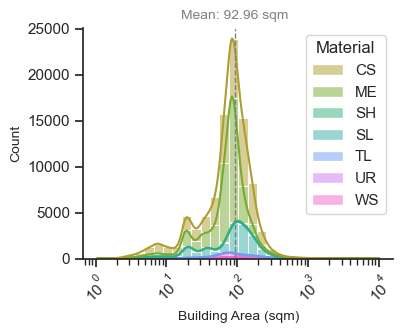

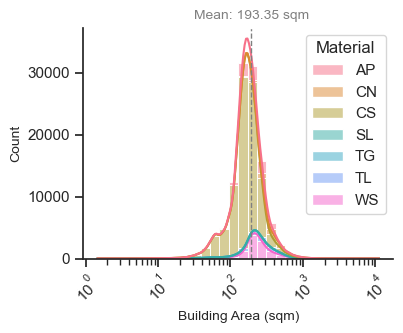

In [10]:
# Set Seaborn theme for consistency
sns.set_theme(style="ticks")

# Loop through the dictionary to create separate histograms
for roi, ref in refs.items():
    ref = ref.sort_values(by='class_code')
    ref['areaUTMsqm'] = ref['areaUTMsqft'] * 0.092903
    
    # Create a figure and axis for each region
    f, ax = plt.subplots(figsize=(4, 3))
    sns.despine(f)

    # Get the color palette
    unique_classes = ref['class_code'].unique()
    region_palette = {cls: color_mapping[cls] for cls in unique_classes if cls in color_mapping}
    
    # Set the x-axis to logarithmic scale with appropriate ticks
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xticks([0.1, 10, 100, 1000, 10000, 100000])
    ax.set_yscale('linear')  # Keep the y-axis linear unless you want log scale
    
    # Create a histogram colored by class_code
    hist = sns.histplot(
        data=ref, 
        x="areaUTMsqm", 
        bins=30, 
        log_scale=True, 
        kde=True, 
        hue="class_code",  # Color by class_code
        multiple="stack",  # Stack the bars for each class
        palette=region_palette,  # You can use class_palette if you have a custom one
        legend=True
    )

    # Calculate the overall mean of 'areaUTMsqft'
    area_mean = ref['areaUTMsqm'].mean() # in sqm

    # Add a vertical dotted line for the mean
    ax.axvline(area_mean, color='gray', linestyle='--', linewidth=1)

    # Add a text label for the mean
    ax.text(
        area_mean, ax.get_ylim()[1] * 1.05,  # Position: x=area_mean, y=90% of y-axis limit
        f'Mean: {area_mean:.2f} sqm', 
        color='gray', 
        fontsize=10,
        rotation=0, 
        va='center', 
        ha='center',
        backgroundcolor='white'
    )
    
    # Retrieve the legend and set the title
    legend = ax.get_legend()
    legend.set_title('Material')
    
    # Set labels and title
    ax.set_xlabel('Building Area (sqm)', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    plt.xticks(rotation=45)  # Rotate x labels if necessary
               
    # Save the figure
    out_png = os.path.join(projdir,f'figures/Figure1_{roi}_area_dist.png')
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

### Figure X. Hyperparameter tuning

In [11]:
fp = os.path.join(projdir,'results/resnet18/tuning/resnet18_grid_search_results.csv')
tuning_df = pd.read_csv(fp)
tuning_df.head(12)

,trial,epoch,batch_size,window_size,learning_rate,weight_decay,accuracy,f1_score,train_loss,val_loss,time_ep
0,0,1,32,78,0.01,0.00001,38.454576,0.454619,1.772893,1.466633,3.25
1,0,2,32,78,0.01,0.00001,43.240186,0.436734,1.482872,1.456673,3.35
2,0,3,32,78,0.01,0.00001,57.732775,0.583495,1.367790,1.228961,3.42
3,0,4,32,78,0.01,0.00001,50.367689,0.533238,1.230571,1.303825,3.38
4,0,5,32,78,0.01,0.00001,41.022740,0.461519,1.090379,1.758595,3.33
5,0,6,32,78,0.01,0.00001,38.443263,0.441192,0.905829,1.736805,3.38
6,0,7,32,78,0.01,0.00001,49.077950,0.512800,0.747294,1.414276,3.40
7,0,8,32,78,0.01,0.00001,61.217332,0.619434,0.452533,1.197468,3.40
8,0,9,32,78,0.01,0.00001,64.656635,0.645323,0.324811,1.208729,3.45
9,0,10,32,78,0.01,0.00001,64.645322,0.644943,0.273739,1.269782,3.25


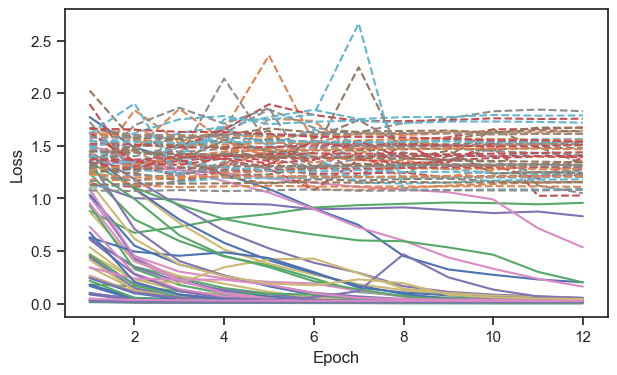

In [12]:
# Create a plot for train and validation losses across trials
plt.figure(figsize=(7, 4))
# Iterate over each trial and plot the losses
for trial in tuning_df['trial'].unique():
    trial_data = tuning_df[tuning_df['trial'] == trial]
    plt.plot(trial_data['epoch'], trial_data['train_loss'], label=f'Trial {trial} - Train', linestyle='-')
    plt.plot(trial_data['epoch'], trial_data['val_loss'], label=f'Trial {trial} - Val', linestyle='--')
# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Training and Validation Losses Across Trials')

out_png = os.path.join(projdir,f'figures/FigureX_{roi}_tuning_train_val_loss.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

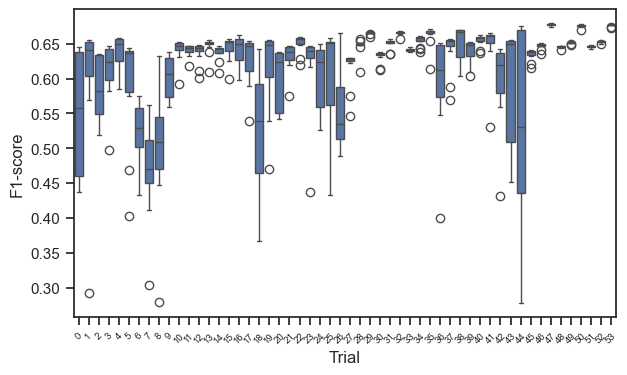

In [13]:
plt.figure(figsize=(7, 4))

sns.boxplot(x='trial', y='f1_score', data=tuning_df)

# Add labels and title
plt.xlabel('Trial')
plt.ylabel('F1-score')
# plt.title('F1 Score Distribution Across Epochs for Each Trial')
plt.xticks(rotation=45, size=7)  # Rotate trial labels for better readability if necessary

# Save the figure 
out_png = os.path.join(projdir,f'figures/FigureX_{roi}_tuning_f1score.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
#### Spectral response